In [ ]:
from IPython.display import clear_output

In [ ]:
# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install torch
%pip install matplotlib
%pip install torchvision

clear_output()

In [ ]:
import torch

import torch.nn as nn

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.optim import Adam

from torchvision.transforms.functional import to_tensor

import matplotlib.pyplot as plt

#Contents:

1. Implementation of 1-2 layer NN fin pytorch which classifies MNIST dataset

About MNIST:

the dataset consists of images of 28x28 size. The image each contains a handwritten digit from 0 to 9. Our model needs to take this image and classify it to the correct digit.


You need to know:

1. **pytorch** (for impelementation)
2. a little bit of **matplotlib** (for visualization)


Good to have knowledge of:

1. torch dataset and dataloader

In [ ]:
# MNIST function fetches the MNIST dataset. Without any transform param, the returned object is a Pillow image but we want to convert it to numerical form
# that is to say, a numpy array/torch tensor

# to_tensor is used to avoid errors when creating data loader later. we'll convert them to numpy arrays when the time comes
train_data = MNIST(root='./datasets', train=True, download=True, transform=to_tensor)
test_data  = MNIST(root='./datasets', train=False, download=True, transform=to_tensor)

# clear_output()

100%|██████████| 9912422/9912422 [00:00<00:00, 141558913.19it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 34354989.74it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47053922.33it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15955216.72it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [ ]:
batch_size = 64

# Dataloaders are used to easily create batches of data so we can perform batch gradient descent for faster learning
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

## Models

let's create the architecture of our models

Instead of sigmoid activation, we'll use softmax activation

The difference is:
- sigmoid brings each value in the range 0-1
- softmax takes a vector and changes the value into probabilities: i.e the sum of those values = 1. The highest value in the original vector retains the highest value in softmax output

Here's the formula for softmax:

$$
\text{Softmax}(x)_i = \frac{e^{x_i}}{\sum_{j} e^{x_j}}
$$

In [ ]:
class NN1Layer(nn.Module):

  def __init__(self, num_inp, num_out):

    super(NN1Layer, self).__init__()

    self.layer_1 = nn.Linear(#TODO, #TODO)
    self.softmax = nn.Softmax(dim = 1) # dim 0 is normally batch size, we don't want to apply softmax across batch size

  def forward(self, x):

    z = self.layer_1(#TODO)
    a = self.softmax(#TODO)

    return a


class NN2Layer(nn.Module):

  def __init__(self, num_inp, num_hidden, num_out):

    super(NN2Layer, self).__init__()

    self.layer_1 = nn.Linear(#TODO, #TODO)
    self.layer_2 = nn.Linear(#TODO, #TODO)

    self.hidden_activation = nn.ReLU()  # We can change the hidden activation (activation in between layer 1 and 2) here
    self.softmax = nn.Softmax(dim=1)  # dim 0 is normally batch size, we don't want to apply softmax across batch size

  def forward(self, x):

    z1 = self.layer_1(#TODO)
    a1 = self.hidden_activation(#TODO)

    z2 = self.layer_2(#TODO)
    a2 = self.softmax(#TODO)

    return a2

## The main training loop, with batch gradient descent.



Declare model, it's params, optimizers and criterion etc

We'll also declare a device here. This will let us use GPU
you can see how much difference a GPU makes by changing the device param to cpu and cuda

In [ ]:
num_epochs = #TODO
lr = #TODO

device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu

train_losses = []
val_losses = []

# model = NN1Layer(28*28, 10)  # 28*28 because that's the input side. 10 because that's the numbber of classes (0-9)
model = NN2Layer(#TODO, #TODO, #TODO)  # The 2 layer one is equivalent to the one we implemented in numpy

optimizer = Adam(model.parameters(), lr=lr)
criterion =  #TODO # What is the loss used for multi-class classification?

model.to(device)  # we need to send all input tensors as well as our model to this device. by default they are on cpu

print(f'Using device {device}')

Using device cpu


Pre-train performance

In [ ]:
%%time
model.eval()
correctly_labelled = 0

with torch.no_grad():

  val_epoch_weighted_loss = 0

  for val_batch_X, val_batch_y in test_loader:

    val_batch_X = val_batch_X.view(-1, 28*28).to(device)
    val_batch_y = val_batch_y.to(device)

    val_batch_y_probs = model(#TODO)

    loss = criterion(#TODO, #TODO)
    val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

    val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

    correctly_labelled += (#TODO).sum().item()  # item converts tensor to float/int/list

val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
val_losses.append(#TODO)

print(f'val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

val_loss=2.3022759841918945. labelled 852/10000 correctly (8.52% accuracy)
CPU times: user 1.01 s, sys: 2.98 ms, total: 1.01 s
Wall time: 1.02 s


Training the model

In [ ]:
%%time
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.view(-1, 28*28).to(device)  # convert to [N, 28*28] shape where N is batch_size
    batch_y = batch_y.to(device)

    batch_y_probs = model(#TODO)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

    loss = criterion(#TODO, #TODO)

    optimizer.zero_grad()  # need to clear out gradients from previous batch
    loss.backward()  # calculate new gradients
    optimizer.step()  # update weights

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(#TODO)    # add loss for tracking. we'll visualize the loss trajectory later


  # validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0

  with torch.no_grad():  # this makes our model to NOT track gradients

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in test_loader:

      val_batch_X = val_batch_X.view(-1, 28*28).to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs = model(#TODO)

      loss = criterion(#TODO, #TODO)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

      correctly_labelled += (#TODO).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
  val_losses.append(#TODO)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}. Change device variable and run again to see the difference.')

Epoch: 0, train_loss=1.8569024538675944, val_loss=1.6790217945098878. labelled 8298/10000 correctly (82.98% accuracy)
Epoch: 1, train_loss=1.6588228879292806, val_loss=1.6092724439620971. labelled 8940/10000 correctly (89.4% accuracy)
Epoch: 2, train_loss=1.5922240472157796, val_loss=1.573629927253723. labelled 9111/10000 correctly (91.11% accuracy)
Epoch: 3, train_loss=1.5712697951634724, val_loss=1.56124711227417. labelled 9173/10000 correctly (91.73% accuracy)
Epoch: 4, train_loss=1.5608021940867105, val_loss=1.553661266899109. labelled 9216/10000 correctly (92.16% accuracy)
Epoch: 5, train_loss=1.5536845936457315, val_loss=1.548231986618042. labelled 9255/10000 correctly (92.55% accuracy)
Epoch: 6, train_loss=1.5482194595336913, val_loss=1.544000549888611. labelled 9282/10000 correctly (92.82000000000001% accuracy)
Epoch: 7, train_loss=1.543736826833089, val_loss=1.5405067050933838. labelled 9306/10000 correctly (93.06% accuracy)
Epoch: 8, train_loss=1.539898034922282, val_loss=1.5

Loss trajectory

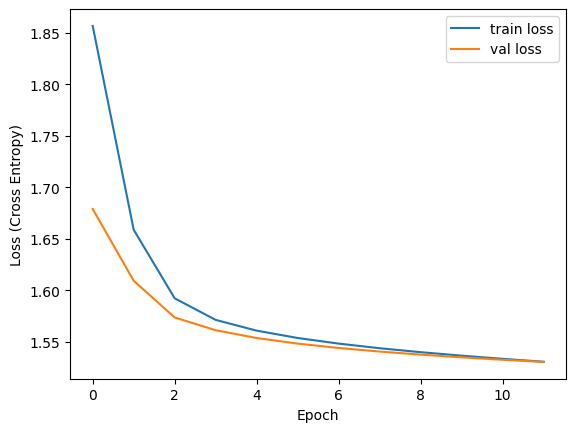

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()

visualizing shapes

In [ ]:
print(val_batch_X.shape, val_batch_y.shape)  # 784 is 28*28
print(val_batch_y_probs.shape)  # inference from model
print(val_batch_y_pred.shape)  # probabilities converted

print("\n\nTo verify softmax converts inputs into probabilities (sum of which is 1), let's sum those probabilities and see if we get 1's: \n")
print(f'{val_batch_y_probs.sum(1)=}')

print(f'\n{val_batch_y_probs.sum(1).shape=}')

print('\n\nLets see argmax in action')
print("Here's one of the input to argmax\n")
test_idx = 15
print(val_batch_y_probs[test_idx].cpu())  # .cpu() brings a tensor back to cpu device from any other it might be on (like cuda)
print("\n\nHere's its output")
print(val_batch_y_pred[test_idx].cpu())

torch.Size([16, 784]) torch.Size([16])
torch.Size([16, 10])
torch.Size([16])


To verify softmax converts inputs into probabilities (sum of which is 1), let's sum those probabilities and see if we get 1's: 

val_batch_y_probs.sum(1)=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')

val_batch_y_probs.sum(1).shape=torch.Size([16])


Lets see argmax in action
Here's one of the input to argmax

tensor([1.1285e-08, 4.4655e-19, 6.2781e-08, 6.1962e-15, 6.7458e-10, 1.0998e-09,
        1.0000e+00, 7.2215e-16, 5.7597e-12, 8.7722e-14])


Here's its output
tensor(6)


Saving and loading the model

In [ ]:
# you can load save the model's state dict like this
torch.save(model.state_dict(), 'MNIST_classifier.pt')  # take a look at the storage section if you're on colab

END.